In [1]:
%load_ext autoreload
%autoreload 2

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/earthpulse/pytorch_eo/blob/master/examples/eurosat_advanced.ipynb)

In this advanced example we are going to train an image classifier with the [EuroSAT](https://github.com/phelber/EuroSAT) dataset exploring the different features of Pytorch EO. In the simple example we saw how to train a model on the RGB version of EuroSAT. Here, we are going to use the full Sentinel 2 images.

In [50]:
from pytorch_eo.datasets import EuroSATRGB, EuroSAT
from pytorch_eo.datasets.sensors import S2

# RGB variant
#ds = EuroSATRGB(batch_size=25, verbose=True)

# MS variant, choose one band or a combination of bands
# you can use the RGB and ALL shortcuts 
#ds = EuroSAT(batch_size=25, bands=S2.RGB, verbose=True)
#ds = EuroSAT(batch_size=25, bands=[S2.B04, S2.B03, S2.B02], verbose=True)
#ds = EuroSAT(batch_size=25, bands=[S2.nir1, S2.green, S2.blue], verbose=True) # false color
#ds = EuroSAT(batch_size=25, bands=S2.B01, verbose=True) 
#ds = EuroSAT(batch_size=25, bands=S2.ALL, verbose=True) 
ds = EuroSAT(batch_size=25, verbose=True) 

ds.setup()

data already extracted !
Number of images: 27000
Training samples 16200
Validation samples 5400
Test samples 5400


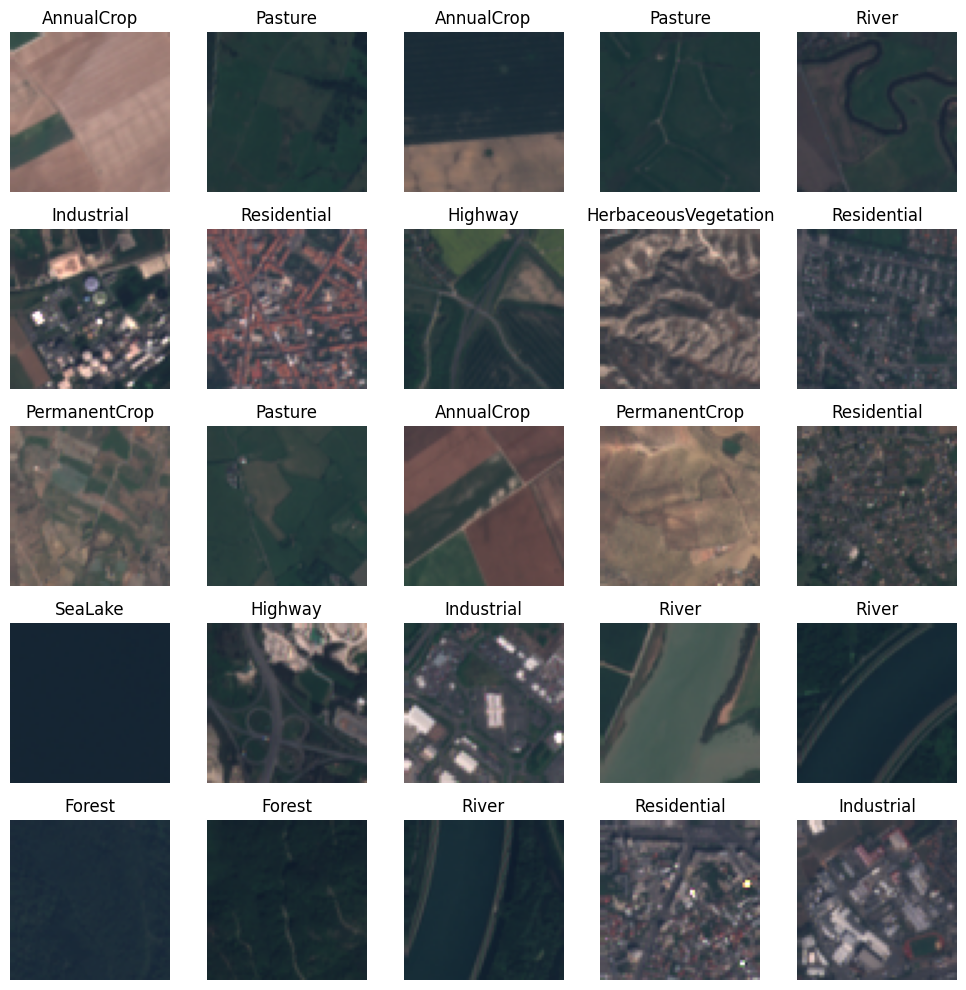

In [51]:
import matplotlib.pyplot as plt
from pytorch_eo.utils.image import to_uint8

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['label']

fig = plt.figure(figsize=(10, 10))
th = 4000
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    if img.ndim < 3:
        ax.imshow(img, cmap="gray")
    else:
        if img.size(-1) == 3:
            ax.imshow(to_uint8(img, 0, th))
        else:
            ax.imshow(to_uint8(img[...,(3,2,1)], 0, th))
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

The dataset has multiple objects that we can use to inspect the data: 
- images and labels are lists with the images paths and the ground truth
- train_idxs, val_idxs, test_idxs contain the indexes of the train, validation and test splits
- classes is the list of classes (the label is the index in the list).

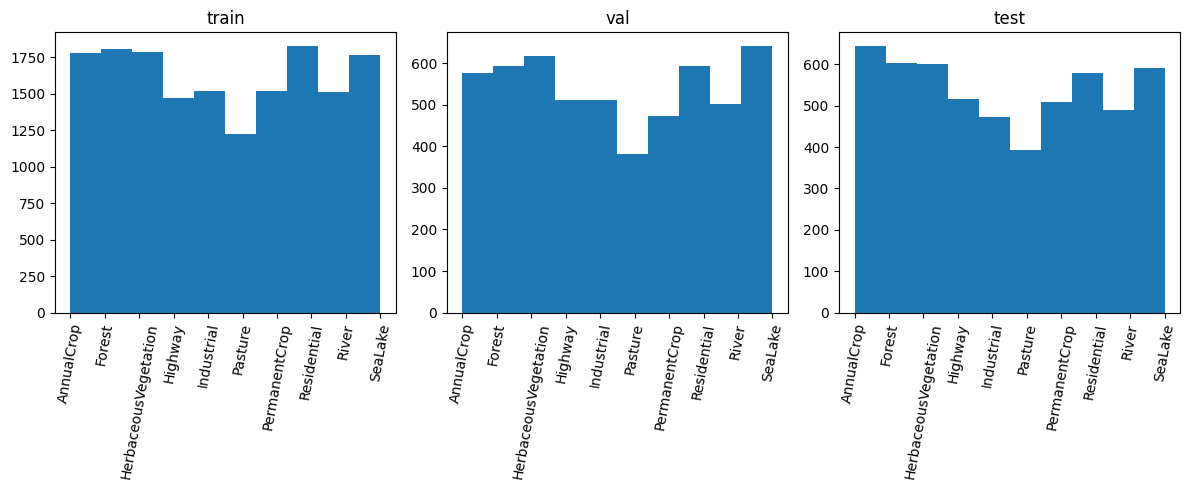

In [52]:
# label distribution

import numpy as np 
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))
ax = plt.subplot(1,3,1)
ax.hist(ds.train_df.label, bins=len(ds.classes))
ax.set_title('train')
ax.set_xticks(list(range(len(ds.classes))))
ax.set_xticklabels(ds.classes, rotation=80)
ax = plt.subplot(1,3,2)
ax.hist(ds.val_df.label, bins=len(ds.classes))
ax.set_title('val')
ax.set_xticks(list(range(len(ds.classes))))
ax.set_xticklabels(ds.classes, rotation=80)
ax = plt.subplot(1,3,3)
ax.hist(ds.test_df.label, bins=len(ds.classes))
ax.set_title('test')
ax.set_xticks(list(range(len(ds.classes))))
ax.set_xticklabels(ds.classes, rotation=80)
plt.tight_layout()
plt.show()

In the simple example we used `timm` to use a `resnet18` as a model. Here, we are going to build our own neural network using `torchvision`.

In [53]:
import torchvision
import torch

model = torchvision.models.resnet18()
model.fc = torch.nn.Linear(512, ds.num_classes)

output = model(torch.randn(8, 3, 224, 224))
output.shape
        

torch.Size([8, 10])

We will also use data augmentation.

In [54]:
import albumentations as A
from einops import rearrange
from albumentations.pytorch import ToTensorV2

def clip(x, **kwargs): return np.clip(x, 0., 1.)
def add_channel(x, **kwargs): return rearrange(x, 'h w -> h w 1') if x.ndim == 2 else x

trans = A.Compose([
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Normalize(0, 1, max_pixel_value=4000),    # divide by 4000
    A.Lambda(image=clip),                       # clip to [0,1]
    A.Lambda(image=add_channel),                # add channel dimension if only one band
    ToTensorV2()                                # convert to float tensor and channel first
])

ds = EuroSAT(batch_size=25, train_trans=trans) 
ds.setup()

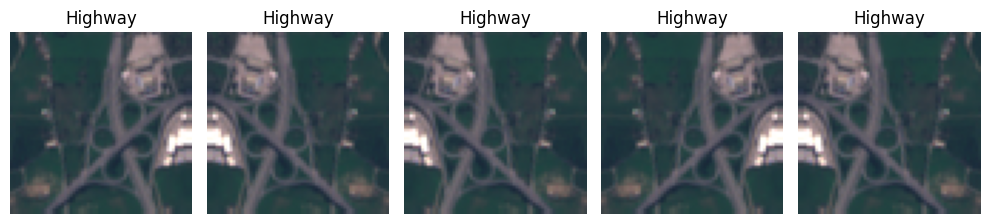

In [55]:
fig = plt.figure(figsize=(10, 10))
rounds = 5
for i, img in enumerate(range(rounds)):
    ax = plt.subplot(1, rounds, i + 1)
    batch = ds.train_ds[10] 
    img, label = batch['image'], batch['label']
    if img.size(0) == 1: # one band
        ax.imshow(img[0], cmap="gray")
    else:
        if img.size(-1) == 3: # rgb
            ax.imshow(img.permute(1,2,0))
        else: # multiple bands with RGB in bands 3,2,1
            ax.imshow(img[(3,2,1),...].permute(1,2,0))
    ax.set_title(ds.classes[label])
    ax.axis('off')
plt.tight_layout()
plt.show()

Besides the `model` we can define hyperparameters in the `hparams` object as well as `metrics`.

In [60]:
import pytorch_lightning as pl
from pytorch_eo.tasks.classification import ImageClassification
from pytorch_eo.metrics.classification import accuracy

val_test_trans = A.Compose([
    A.Normalize(0, 1, max_pixel_value=4000),    
    A.Lambda(image=clip),                       
    A.Lambda(image=add_channel),                
    ToTensorV2()                                
])
ds = EuroSATRGB(batch_size=1024, train_trans=trans, val_trans=val_test_trans, test_trans=val_test_trans)

model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
model.fc = torch.nn.Linear(512, ds.num_classes)

hparams = {
    'optimizer': 'SGD',
    'optim_params': {
        'lr': 1e-3,
        'momentum': 0.9,
        'weight_decay': 1e-2
    },
    'scheduler': 'StepLR',
    'scheduler_params': {
        'step_size': 3,
        'gamma': 0.1,
        'verbose': True
    }
}

metrics = {'acc': accuracy} 

task = ImageClassification(model, hparams=hparams, metrics=metrics)

We use Pytorch Lightning for training.

In [61]:
trainer = pl.Trainer(
    gpus=1,
    max_epochs=10,
)

trainer.fit(task, ds)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | ResNet           | 11.2 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Adjusting learning rate of group 0 to 1.0000e-03.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [62]:
trainer.test(dataloaders=ds.test_dataloader())

/home/juan/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at /home/juan/Desktop/pytorch_eo/examples/lightning_logs/version_5/checkpoints/epoch=9-step=160.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from checkp

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8688889145851135
        test_loss           0.4758020043373108
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.4758020043373108, 'test_acc': 0.8688889145851135}]

You can check your logs with Tensorboard (by default) or with any other logger supported in Pytorch Lightning.